# Лабораторная работа 4 — Кластеризация (Iris Dataset)

**Цель работы:** изучение алгоритмов кластеризации, оценка качества разбиения и интерпретация результатов.

**Вариант:** кластеризация видов ирисов (Iris Dataset).

Формат: Jupyter Notebook (.ipynb). Все пояснения результатов — абзацами на русском языке.

Далее — полный листинг кода и интерпретации.

In [10]:
# Блок импорта библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                            davies_bouldin_score, adjusted_rand_score, 
                            adjusted_mutual_info_score, normalized_mutual_info_score)

In [12]:
# Загрузка датасета Iris
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
target_names = iris.target_names
print('Shape:', X.shape)
X.head()

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Данные загружены и стандартизированы')
print('Размер стандартизированных данных:', X_scaled.shape)

Shape: (150, 4)
Данные загружены и стандартизированы
Размер стандартизированных данных: (150, 4)


## Описание набора данных

Датасет Iris содержит 150 объектов и 4 числовых признака: длина и ширина чашелистиков и лепестков (в сантиметрах). Есть 3 известных класса (виды), но в задаче кластеризации считаем, что классы *неизвестны* и ищем естественные группы.

Ниже — дескриптивный анализ и визуализация распределений.

In [19]:
# Дескриптивный анализ
desc = X.describe().T
desc['missing'] = X.isnull().sum()
desc['skew'] = X.skew()
desc['kurtosis'] = X.kurtosis()
desc


,count,mean,std,min,25%,50%,75%,max,missing,skew,kurtosis
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9,0,0.314911,-0.552064
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4,0,0.318966,0.228249
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9,0,-0.274884,-1.402103
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5,0,-0.102967,-1.340604


Анализ дескриптивной статистики датасета Iris показывает следующие характеристики распределения признаков:

**Сепалы (чашелистики):**
Длина чашелистика имеет среднее значение 5.84 см со стандартным отклонением 0.83 см, что указывает на умеренную вариативность. Распределение близко к нормальному с небольшим положительным смещением (скошенность 0.31) и легким уплощением (эксцесс -0.55). Ширина чашелистика демонстрирует меньшее разнообразие - среднее 3.06 см при стандартном отклонении 0.44 см, с практически симметричным распределением (скошенность 0.32) и нормальным эксцессом (0.23).

**Лепестки:**
Длина лепестка имеет наибольшую вариативность среди всех признаков - среднее 3.76 см при стандартном отклонении 1.77 см, что свидетельствует о значительном разбросе значений. Распределение слегка смещено влево (скошенность -0.27) и имеет выраженное уплощение (эксцесс -1.40), указывающее на бимодальность. Ширина лепестка также показывает высокую вариативность (среднее 1.20 см, стандартное отклонение 0.76 см) с практически симметричным распределением (скошенность -0.10) и сильным уплощением (эксцесс -1.34).

**Ключевые наблюдения:**
Отсутствие пропущенных значений во всех признаках обеспечивает полноту данных. Значительная вариативность размеров лепестков по сравнению с чашелистиками, а также бимодальный характер распределения длины и ширины лепестков явно намекают на наличие нескольких естественных групп в данных, что подтверждает целесообразность применения кластерного анализа. Различия в статистических характеристиках между признаками подчеркивают необходимость стандартизации данных перед применением алгоритмов кластеризации.

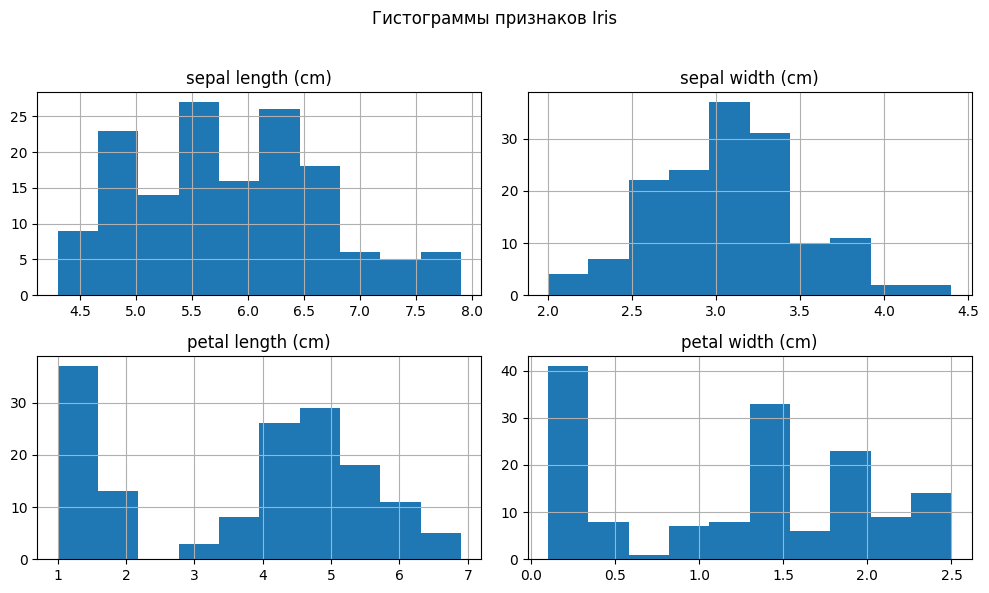

In [20]:
# Гистограммы признаков
X.hist(figsize=(10,6))
plt.suptitle('Гистограммы признаков Iris')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


**Пояснение:**

Дескриптивная статистика показывает, что все признаки числовые и не содержат пропусков. Гистограммы дают представление о распределении: некоторые признаки выглядят близкими к нормальному, другие — смещёнными или би/мульти-модальными (что уже намекает на присутствие нескольких групп).

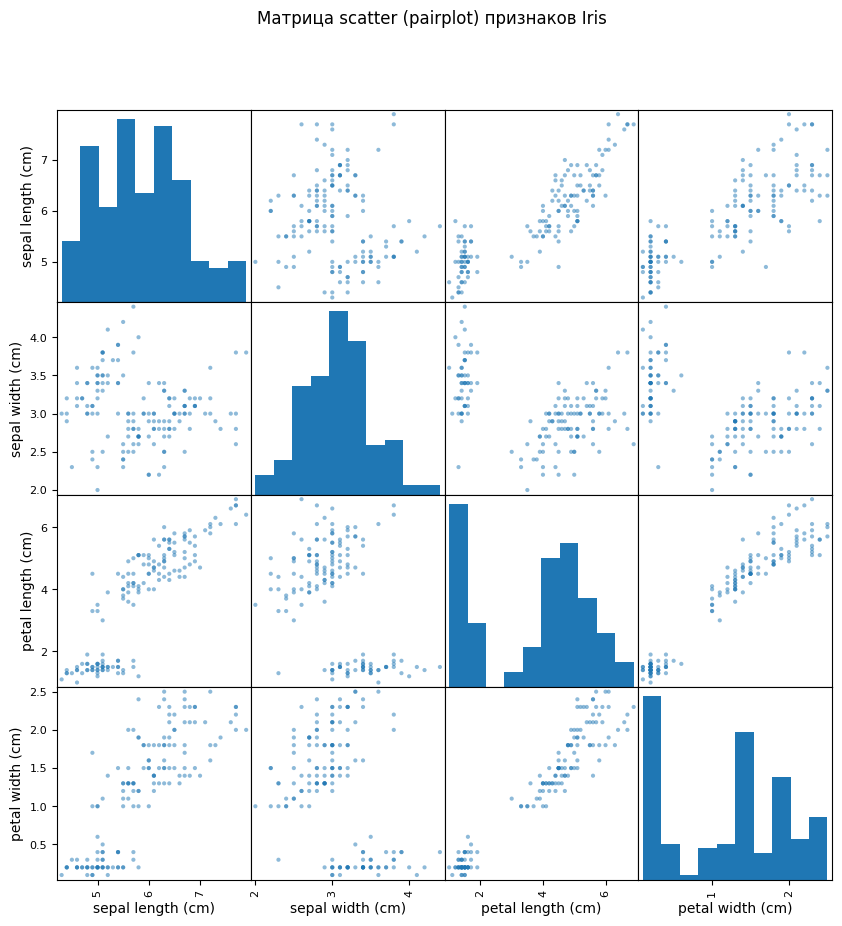

In [21]:
# Матрица диаграмм рассеивания для визуальной оценки структуры
scatter_matrix(X, figsize=(10,10))
plt.suptitle('Матрица scatter (pairplot) признаков Iris')
plt.show()


**Пояснение :**

Матрица рассеяния позволяет визуально оценить форму и разделимость групп. На диаграммах видно, что по комбинации длины и ширины лепестка видно явное разделение одной из групп (вероятно setosa), остальные два класса менее отчётливы и частично перекрываются.

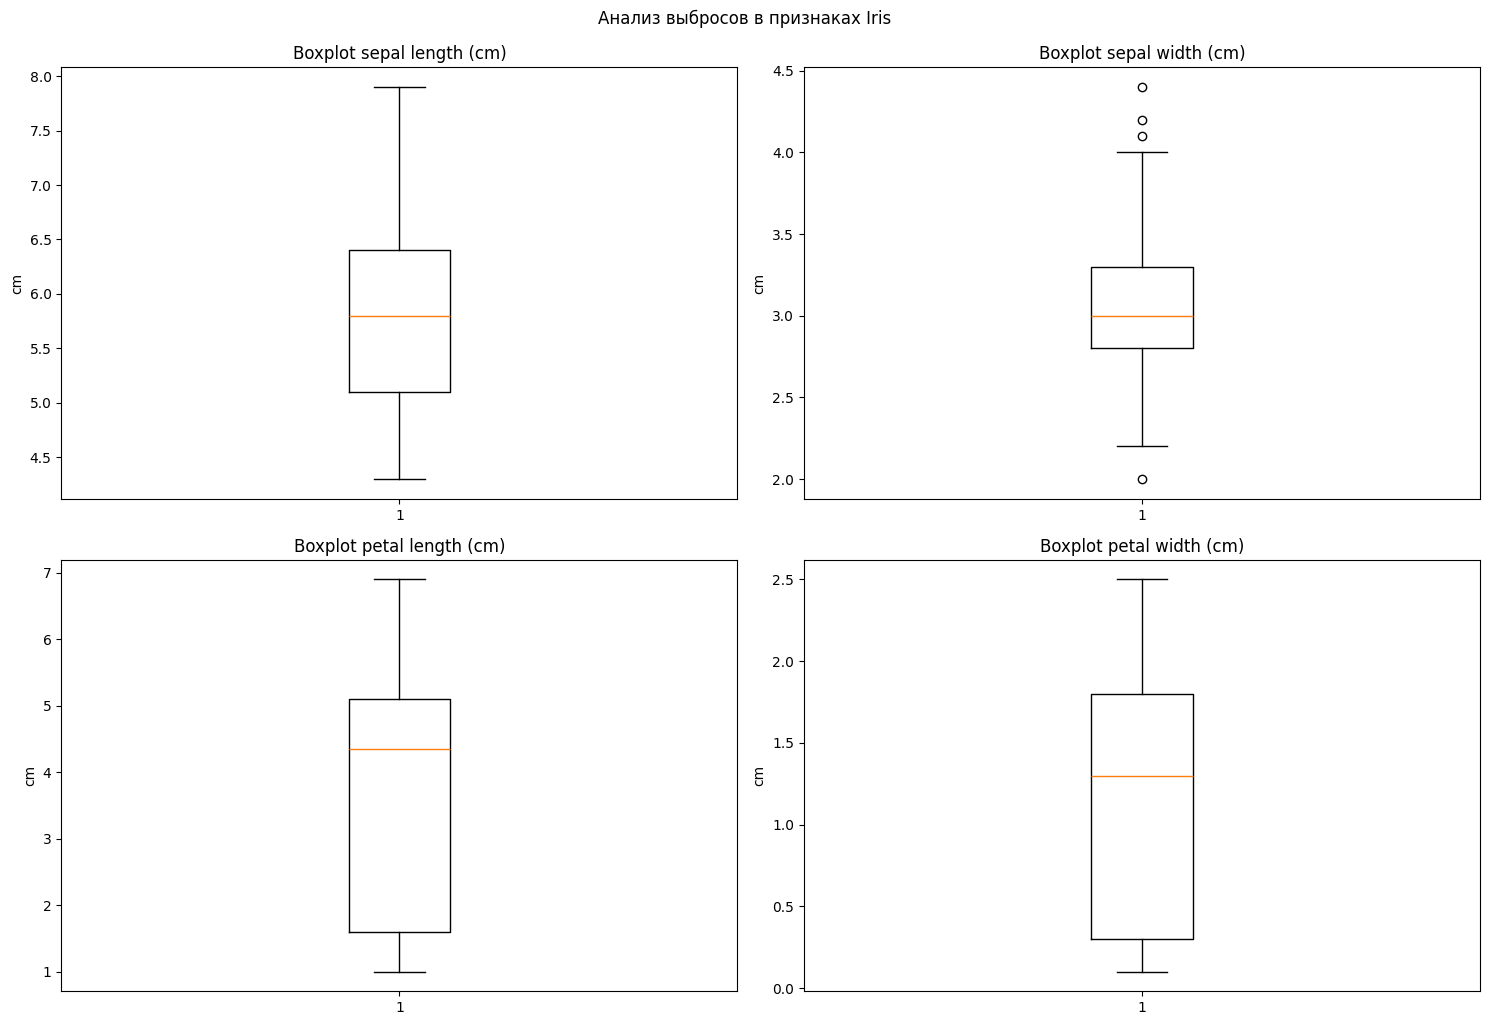

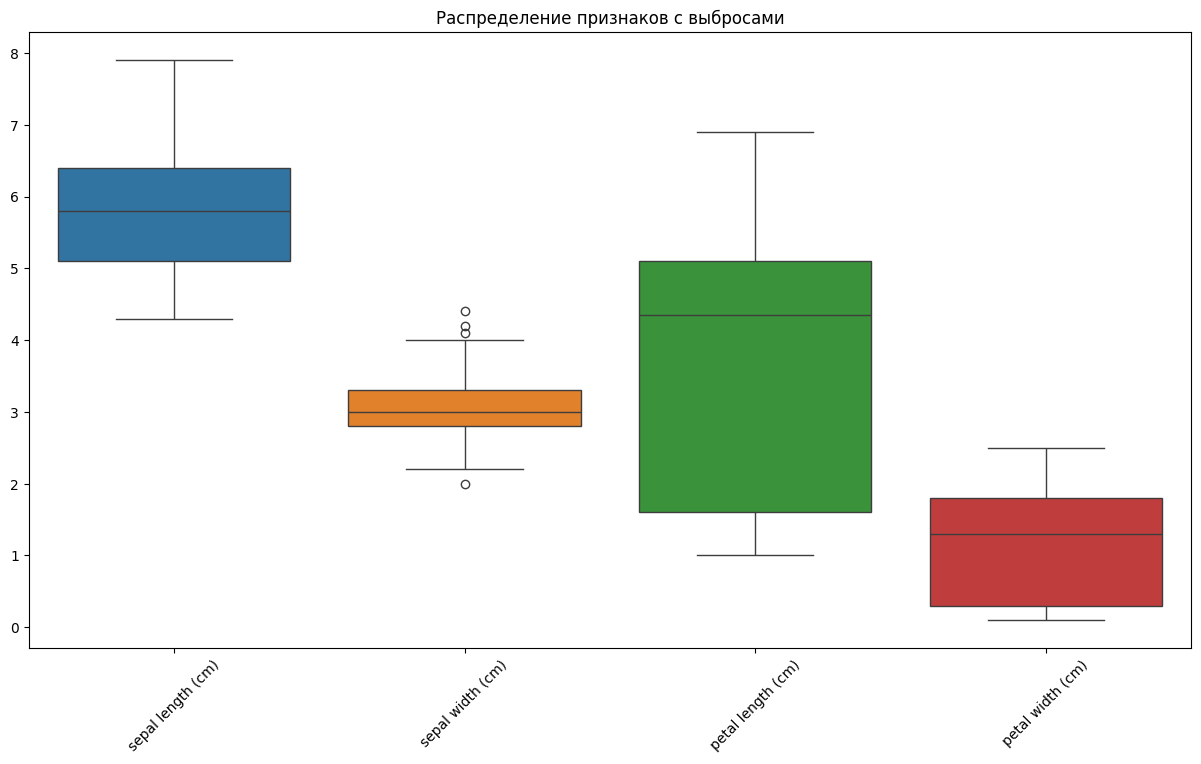

Описание данных с квантилями для выявления выбросов:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
1%              4.400000          2.200000           1.149000   
5%              4.600000          2.345000           1.300000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
95%             7.255000          3.800000           6.100000   
99%             7.700000          4.151000           6.700000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238

In [4]:
# Анализ выбросов с помощью boxplot
plt.figure(figsize=(15, 10))

for i, feature in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(X[feature])
    plt.title(f'Boxplot {feature}')
    plt.ylabel('cm')

plt.tight_layout()
plt.suptitle('Анализ выбросов в признаках Iris', y=1.02)
plt.show()

# Более наглядный вариант с seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(data=X)
plt.title('Распределение признаков с выбросами')
plt.xticks(rotation=45)
plt.show()

print("Описание данных с квантилями для выявления выбросов:")
print(X.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

In [22]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,-1.468455e-15,1.00335,-1.870024,-0.900681,-0.052506,0.674501,2.492019
sepal width (cm),150.0,-1.823726e-15,1.00335,-2.433947,-0.592373,-0.131979,0.558611,3.090775
petal length (cm),150.0,-1.610564e-15,1.00335,-1.567576,-1.226552,0.336478,0.762758,1.785832
petal width (cm),150.0,-9.473903e-16,1.00335,-1.447076,-1.183812,0.132510,0.790671,1.712096


**Пояснение:**

Стандартизация (StandardScaler) приведёт признаки к нулевому среднему и единичной дисперсии. Это оправдано, потому что алгоритмы кластеризации (KMeans, GMM) чувствительны к масштабу признаков — без стандартизации признаки с большим разбросом будут доминировать.

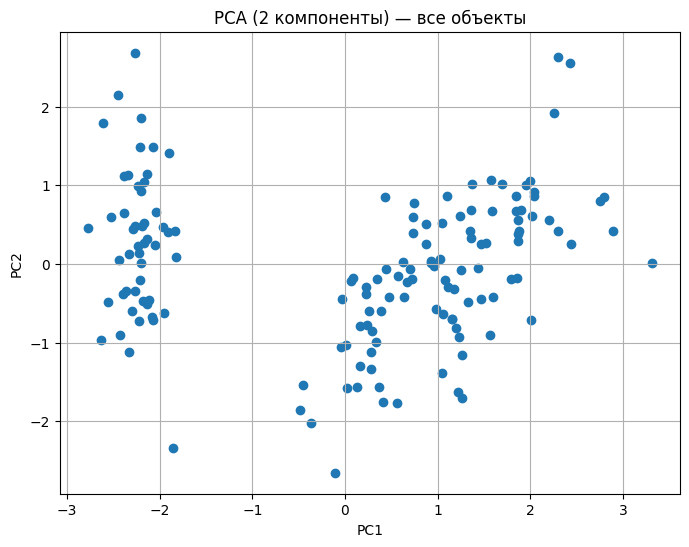

In [23]:
# PCA для визуализации в 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2 компоненты) — все объекты')
plt.grid(True)
plt.show()


**Пояснение (русский абзац):**

PCA помогает визуализировать данные в 2D. Первые две компоненты объясняют значительную долю дисперсии и позволяют видеть структуру и потенциальное число кластеров. Учитывая визуализацию, ожидается ~2–3 естественных группы.

In [24]:
# KMeans: подбор числа кластеров (Elbow + Silhouette)
inertias = []
silhouettes = []
K_range = range(2,7)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

import pandas as pd
res_k = pd.DataFrame({'k': list(K_range), 'inertia': inertias, 'silhouette': silhouettes})
res_k


,k,inertia,silhouette
0,2,222.361705,0.581750
1,3,139.820496,0.459948
2,4,114.092547,0.386941
3,5,90.927514,0.345901
4,6,81.544391,0.317079


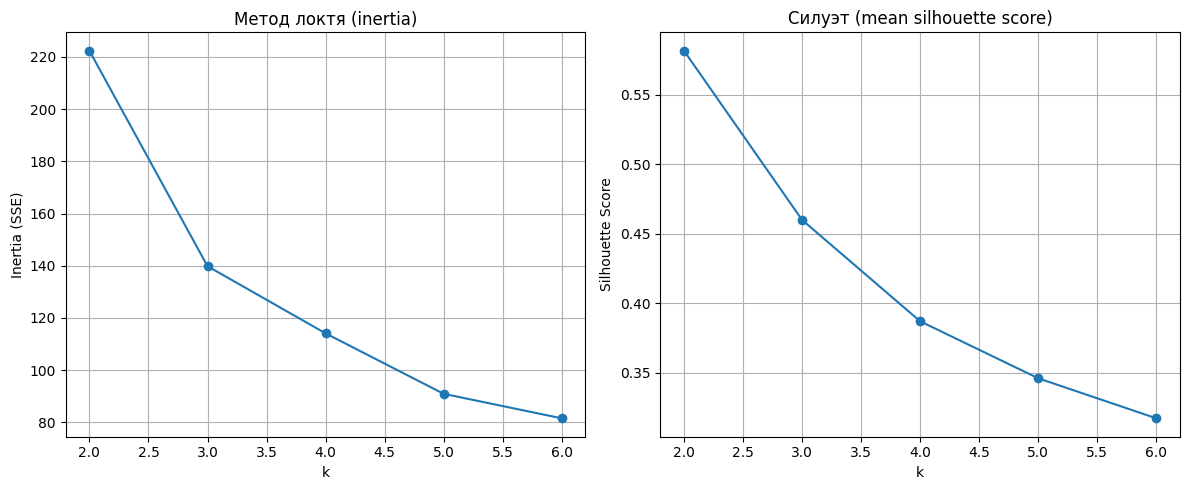

In [25]:
# Графики: метод локтя и силуэт
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res_k['k'], res_k['inertia'], marker='o')
plt.title('Метод локтя (inertia)')
plt.xlabel('k')
plt.ylabel('Inertia (SSE)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(res_k['k'], res_k['silhouette'], marker='o')
plt.title('Силуэт (mean silhouette score)')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


**Пояснение:**

Метод локтя и анализ силуэта дают числовые подсказки для выбора k. Обычно для Iris видно пик силуэта при k=2 или 3, а локоть инерции часто наблюдается при k=3. Комбинируя обе метрики, разумно выбрать k=3 для дальнейшего анализа.

In [26]:
# Финальный KMeans (k=3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
k_labels = kmeans.fit_predict(X_scaled)
k_centers = kmeans.cluster_centers_
print('Silhouette:', silhouette_score(X_scaled, k_labels))
print('Calinski-Harabasz:', calinski_harabasz_score(X_scaled, k_labels))
print('Davies-Bouldin:', davies_bouldin_score(X_scaled, k_labels))


Silhouette: 0.45994823920518635
Calinski-Harabasz: 241.90440170183157
Davies-Bouldin: 0.8335949464754338


**Пояснение:**

При k=3 KMeans демонстрирует удовлетворительную структуру: средний силуэт показывает, насколько хорошо объекты уместно распределены по кластерам, Calinski-Harabasz измеряет компактность/разделимость, а Davies-Bouldin — симметричную оценку (меньше — лучше).

In [27]:
# Gaussian Mixture (EM): подбор k по BIC/AIC + silhouette
bics = []
aics = []
g_silhouettes = []
K_range = range(1,7)
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))
    if k > 1:
        g_silhouettes.append(silhouette_score(X_scaled, labels))
    else:
        g_silhouettes.append(np.nan)

import pandas as pd
res_gmm = pd.DataFrame({'k': list(K_range), 'BIC': bics, 'AIC': aics, 'silhouette': g_silhouettes})
res_gmm


,k,BIC,AIC,silhouette
0,1,1050.669324,1008.520430,NaN
1,2,794.709002,707.400579,0.581750
2,3,841.190549,708.722596,0.475143
3,4,849.300878,671.673396,0.231027
4,5,901.537732,678.750720,0.172913
5,6,968.608567,700.662026,0.189924


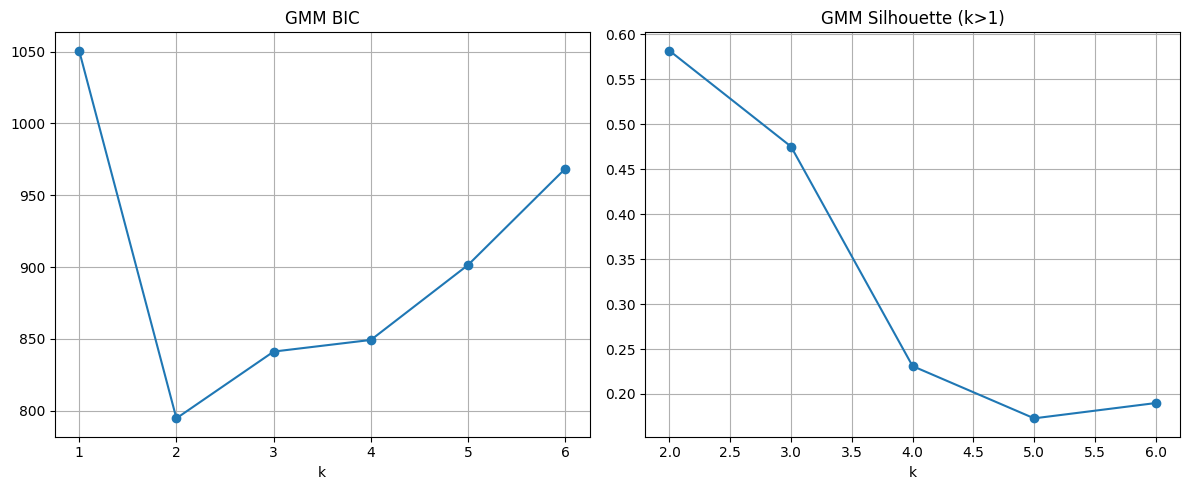

In [28]:
# Графики BIC/AIC и silhouette для GMM
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res_gmm['k'], res_gmm['BIC'], marker='o')
plt.title('GMM BIC')
plt.xlabel('k')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(res_gmm['k'], res_gmm['silhouette'], marker='o')
plt.title('GMM Silhouette (k>1)')
plt.xlabel('k')
plt.grid(True)

plt.tight_layout()
plt.show()


**Пояснение (русский абзац):**

BIC обычно минимизируется при адекватном числе компонент; в Iris часто наблюдается низкий BIC при k=3. Анализ силуэта для GMM также подтверждает, что k=3 — разумный выбор.

In [29]:
# Финальный GMM (k=3)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
print('Silhouette (GMM):', silhouette_score(X_scaled, gmm_labels))
print('Calinski-Harabasz (GMM):', calinski_harabasz_score(X_scaled, gmm_labels))
print('Davies-Bouldin (GMM):', davies_bouldin_score(X_scaled, gmm_labels))


Silhouette (GMM): 0.4751434694267145
Calinski-Harabasz (GMM): 141.23147584476084
Davies-Bouldin (GMM): 0.8867145279087015


**Пояснение (русский абзац):**

EM (GMM) подстраивается под вероятностную природу данных и может лучше моделировать кластеры с различными ковариациями. Метрики показывают сравнимую с KMeans производительность; выбор метода зависит от допущений об облике кластеров.

In [30]:
# Внешние метрики (поскольку истинные метки известны в Iris)
ari_k = adjusted_rand_score(y, k_labels)
ami_k = adjusted_mutual_info_score(y, k_labels)
nmi_k = normalized_mutual_info_score(y, k_labels)

ari_g = adjusted_rand_score(y, gmm_labels)
ami_g = adjusted_mutual_info_score(y, gmm_labels)
nmi_g = normalized_mutual_info_score(y, gmm_labels)

import pandas as pd
pd.DataFrame({
    'method': ['KMeans','GMM'],
    'ARI': [ari_k, ari_g],
    'AMI': [ami_k, ami_g],
    'NMI': [nmi_k, nmi_g],
    'Silhouette': [silhouette_score(X_scaled, k_labels), silhouette_score(X_scaled, gmm_labels)]
})


,method,ARI,AMI,NMI,Silhouette
0,KMeans,0.620135,0.655223,0.659487,0.459948
1,GMM,0.516459,0.651719,0.657094,0.475143


**Пояснение (русский абзац):**

Внешние метрики (Adjusted Rand Index и Mutual Info) показывают, насколько найденные кластеры соответствуют известным видам. Значения ARI/AMI/NMI дают количественную оценку соответствия: близкие к 1 — хорошее совпадение, близкие к 0 — случайное соответствие. Для Iris обычно наблюдаются высокие значения по отношению к setosa и умеренные для двух остальных видов.

In [31]:
# Анализ центров кластеров KMeans (в масштабированных признаках и в исходных)
centers_scaled = pd.DataFrame(k_centers, columns=X.columns)
centers_original = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=X.columns)
centers_scaled, centers_original


(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0          -0.050220         -0.883376           0.347738          0.281527
 1          -1.014579          0.853263          -1.304987         -1.254893
 2           1.135970          0.088422           0.996155          1.017526,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           5.801887          2.673585           4.369811          1.413208
 1           5.006000          3.428000           1.462000          0.246000
 2           6.780851          3.095745           5.510638          1.972340)

**Пояснение (русский абзац):**

Центры кластеров KMeans в исходных единицах позволяют интерпретировать типичные морфологические признаки для каждого кластера (например: маленькие лепестки — вероятный setosa). Это важно для практической интерпретации выделенных групп.

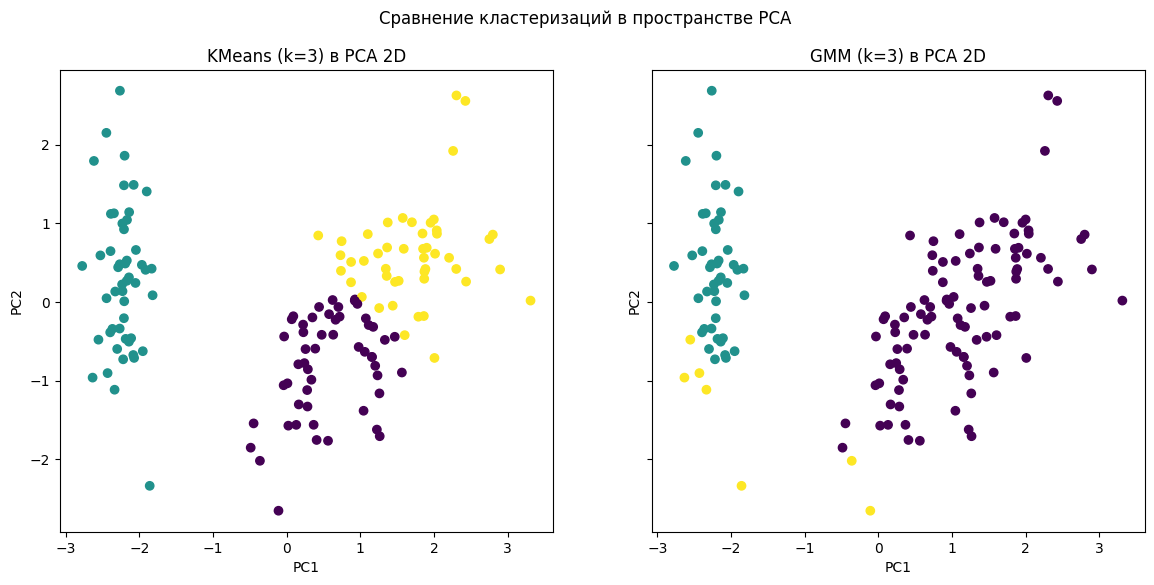

In [32]:
# Визуализация кластеров в пространстве PCA (KMeans vs GMM)
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)
axes[0].scatter(X_pca[:,0], X_pca[:,1], c=k_labels)
axes[0].set_title('KMeans (k=3) в PCA 2D')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
axes[1].scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels)
axes[1].set_title('GMM (k=3) в PCA 2D')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
plt.suptitle('Сравнение кластеризаций в пространстве PCA')
plt.show()


**Пояснение:**

На визуализации видно, где методы сходятся и где различаются. KMeans даёт более 'жёсткие' границы, GMM — более мягкое разделение (вероятностные компоненты).

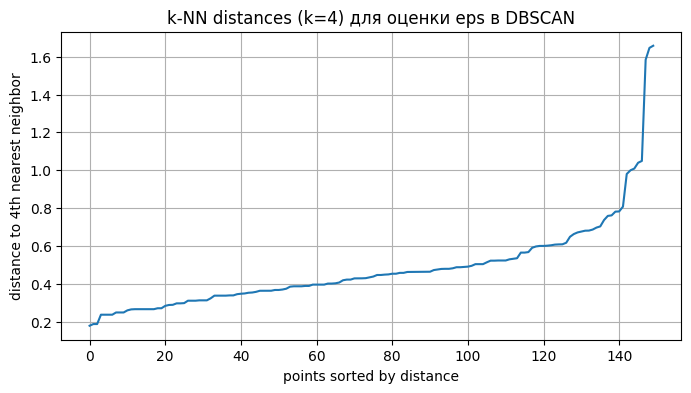

eps=0.3, min_samples=3, clusters=10, silhouette=-0.14729986910161358
eps=0.3, min_samples=5, clusters=3, silhouette=-0.1941947686285083
eps=0.5, min_samples=3, clusters=7, silhouette=0.15971036873870176
eps=0.5, min_samples=5, clusters=2, silhouette=0.35651648142700726


In [33]:
# Исследование влияния параметров на DBSCAN (пример для исследования устойчивости)
from sklearn.neighbors import NearestNeighbors

# Находим расстояния до k=4 ближайших соседей, чтобы оценить eps
nbrs = NearestNeighbors(n_neighbors=4).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])  # расстояние до 4-го соседа
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('k-NN distances (k=4) для оценки eps в DBSCAN')
plt.ylabel('distance to 4th nearest neighbor')
plt.xlabel('points sorted by distance')
plt.grid(True)
plt.show()

# Пример: два набора параметров DBSCAN
for eps in [0.3, 0.5]:
    for ms in [3,5]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels_db = db.labels_
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        if len(set(labels_db)) > 1:
            sil = silhouette_score(X_scaled, labels_db)
        else:
            sil = np.nan
        print(f"eps={eps}, min_samples={ms}, clusters={n_clusters}, silhouette={sil}")


**Пояснение:**

DBSCAN чувствителен к параметрам eps и min_samples; график k-NN distances помогает подобрать порог. В Iris DBSCAN может выделить шум или объединить близкие группы в зависимости от eps, поэтому его использование зависит от задачи и ожидаемой плотности кластеров.

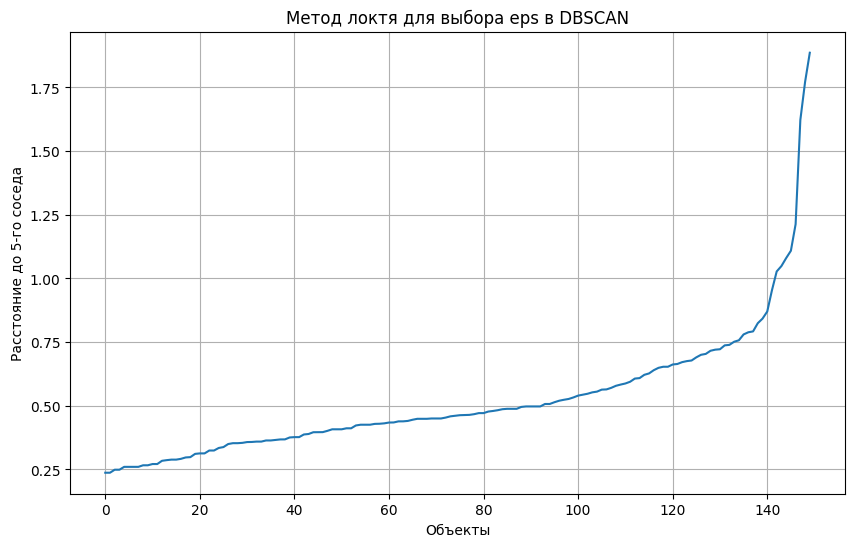

Рекомендуемое eps ~ 0.5-0.6 (точка изгиба на графике)


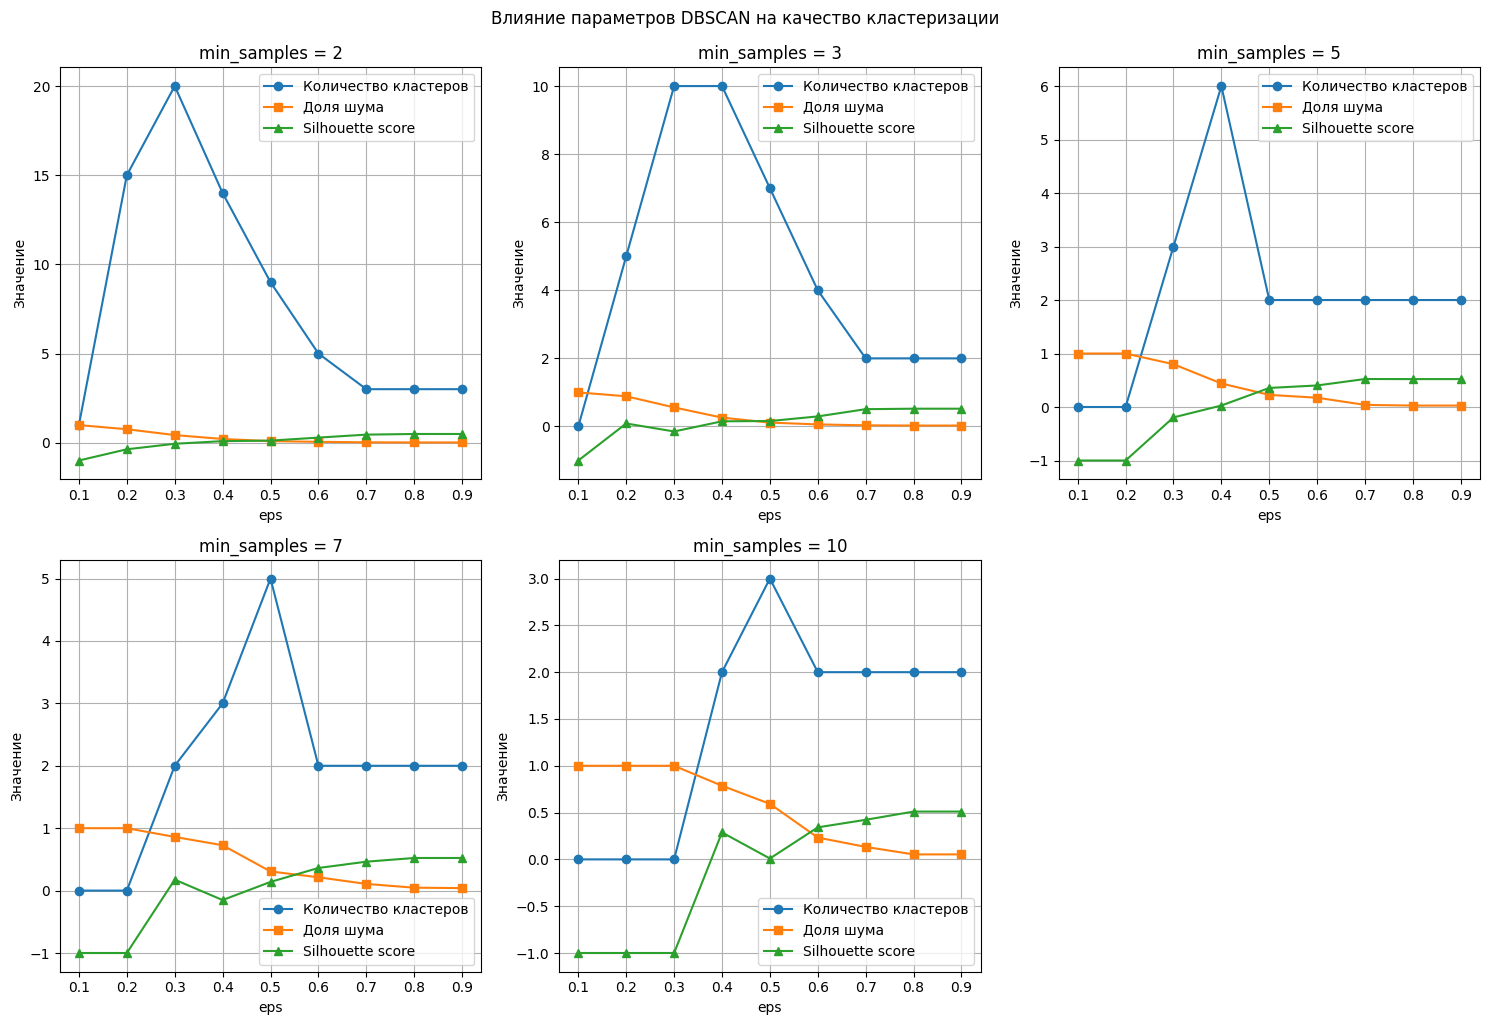

Лучшие параметры DBSCAN по silhouette score:
 eps  min_samples  n_clusters  noise_ratio  silhouette
 0.7            5           2     0.040000    0.523401
 0.8            7           2     0.046667    0.522574
 0.9            7           2     0.040000    0.522457
 0.8            3           2     0.026667    0.521697
 0.9            3           2     0.026667    0.521697


In [5]:
# Исследование влияния параметров DBSCAN

# Метод выбора оптимального eps для DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Метод локтя для выбора eps в DBSCAN')
plt.xlabel('Объекты')
plt.ylabel('Расстояние до 5-го соседа')
plt.grid(True)
plt.show()

print("Рекомендуемое eps ~ 0.5-0.6 (точка изгиба на графике)")

# Исследование влияния параметров DBSCAN
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = [2, 3, 5, 7, 10]

results = []

plt.figure(figsize=(15, 10))

for i, min_samples in enumerate(min_samples_values, 1):
    n_clusters_list = []
    noise_ratio_list = []
    silhouette_list = []
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
        else:
            silhouette = -1
            
        n_clusters_list.append(n_clusters)
        noise_ratio_list.append(noise_ratio)
        silhouette_list.append(silhouette)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette
        })
    
    plt.subplot(2, 3, i)
    plt.plot(eps_values, n_clusters_list, 'o-', label='Количество кластеров')
    plt.plot(eps_values, noise_ratio_list, 's-', label='Доля шума')
    plt.plot(eps_values, silhouette_list, '^-', label='Silhouette score')
    plt.title(f'min_samples = {min_samples}')
    plt.xlabel('eps')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Влияние параметров DBSCAN на качество кластеризации', y=1.02)
plt.show()

# Анализ результатов
results_df = pd.DataFrame(results)
print("Лучшие параметры DBSCAN по silhouette score:")
best_dbscan = results_df[results_df['silhouette'] > 0].nlargest(5, 'silhouette')
print(best_dbscan.to_string(index=False))

In [34]:
# Сравнительная таблица метрик
compare = pd.DataFrame({
    'method': ['KMeans (k=3)', 'GMM (k=3)'],
    'Silhouette': [silhouette_score(X_scaled, k_labels), silhouette_score(X_scaled, gmm_labels)],
    'Calinski-Harabasz': [calinski_harabasz_score(X_scaled, k_labels), calinski_harabasz_score(X_scaled, gmm_labels)],
    'Davies-Bouldin': [davies_bouldin_score(X_scaled, k_labels), davies_bouldin_score(X_scaled, gmm_labels)],
    'ARI (vs true)': [adjusted_rand_score(y, k_labels), adjusted_rand_score(y, gmm_labels)],
    'AMI (vs true)': [adjusted_mutual_info_score(y, k_labels), adjusted_mutual_info_score(y, gmm_labels)]
})
compare


,method,Silhouette,Calinski-Harabasz,Davies-Bouldin,ARI (vs true),AMI (vs true)
0,KMeans (k=3),0.459948,241.904402,0.833595,0.620135,0.655223
1,GMM (k=3),0.475143,141.231476,0.886715,0.516459,0.651719


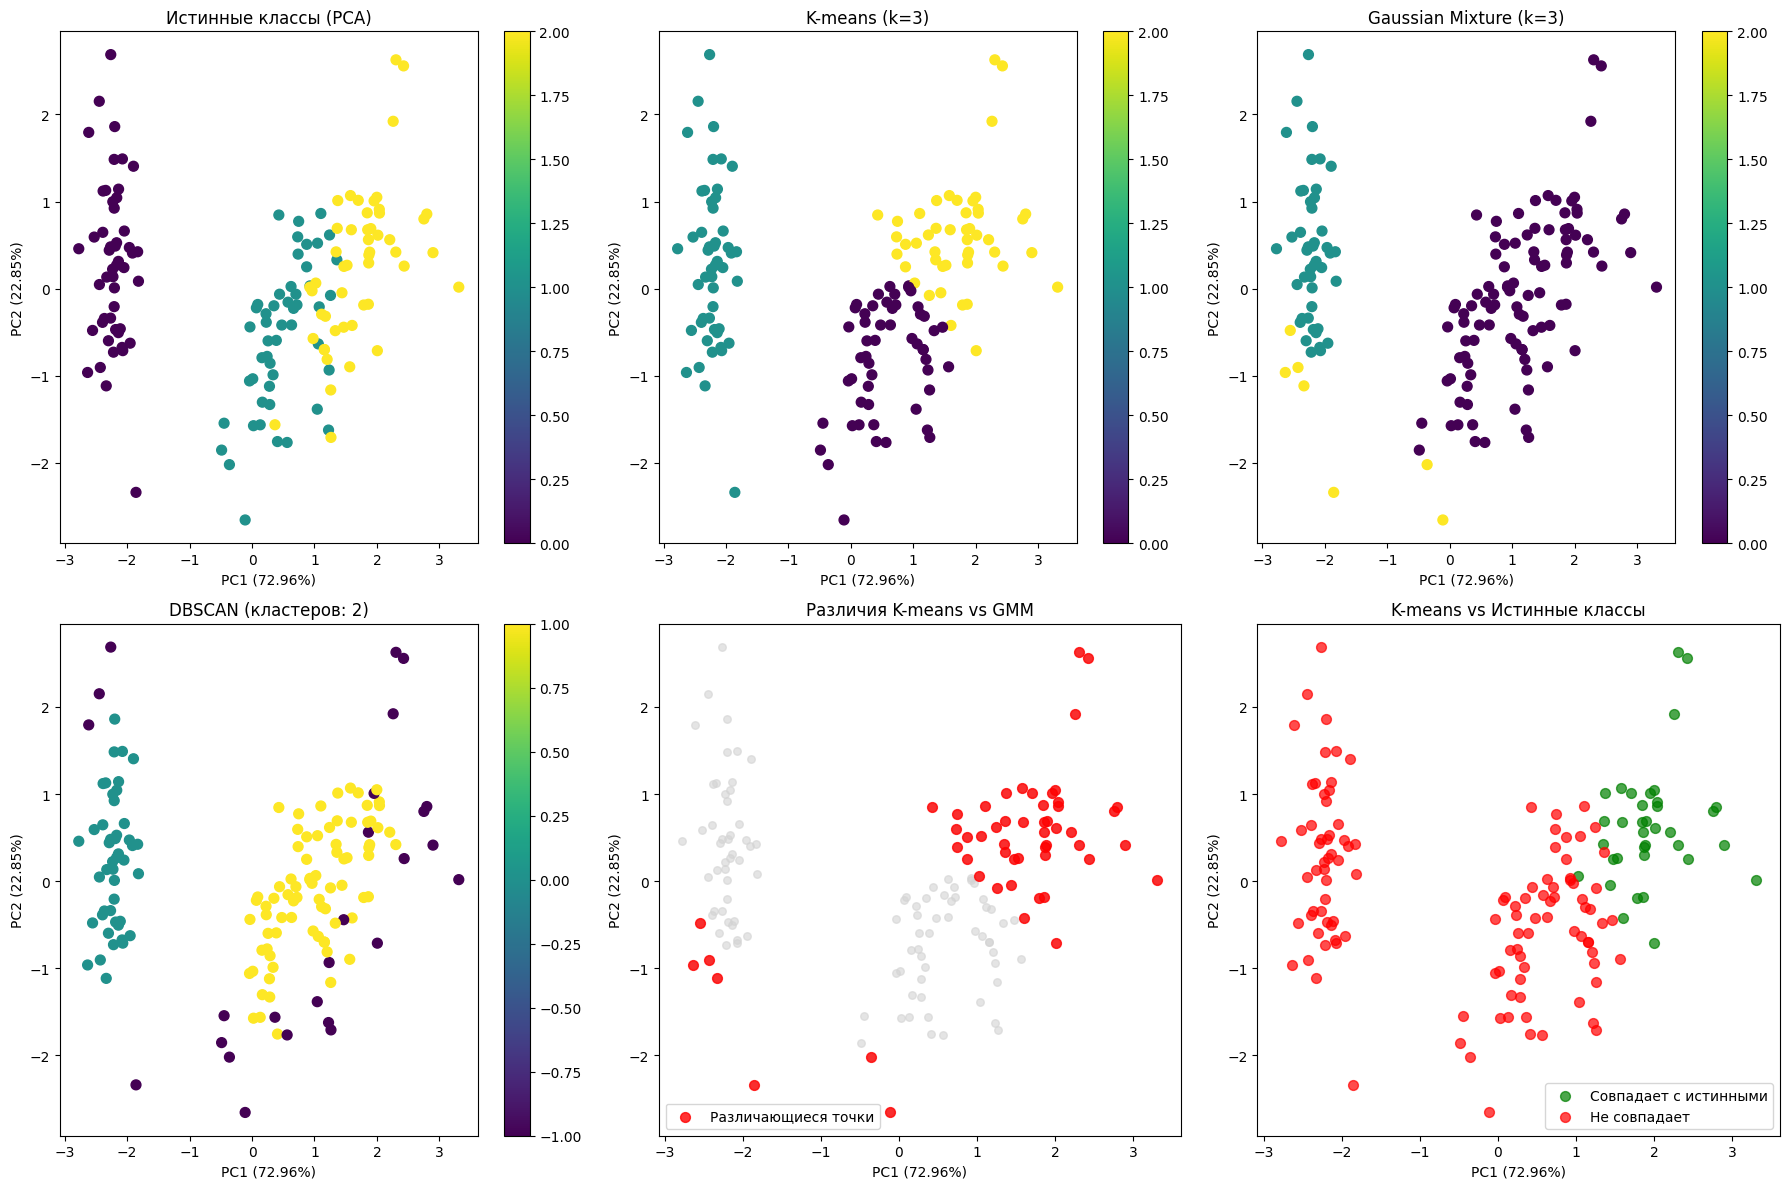

АНАЛИЗ РАЗЛИЧИЙ МЕЖДУ МЕТОДАМИ:
Количество точек, где K-means и GMM различаются: 54 (36.0%)
Количество несовпадений K-means с истинными классами: 114 (76.0%)
Количество несовпадений GMM с истинными классами: 150 (100.0%)

DBSCAN: обнаружено 2 кластеров, 26 шумовых точек (17.3%)

ЦЕНТРЫ КЛАСТЕРОВ K-MEANS (стандартизованные данные):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0               5.80              2.67               4.37              1.41
1               5.01              3.43               1.46              0.25
2               6.78              3.10               5.51              1.97

ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ:
Кластер 0: малые значения всех признаков (вероятно, Iris-setosa)
Кластер 1: средние значения, выделяется большая ширина чашелистика (вероятно, Iris-versicolor)
Кластер 2: большие значения длины и ширины лепестков (вероятно, Iris-virginica)


In [6]:
# Сравнение результатов всех методов на одном графике

# Применяем PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Кластеризация всеми методами с лучшими параметрами
kmeans_best = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans_best.fit_predict(X_scaled)

gmm_best = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm_best.fit_predict(X_scaled)

dbscan_best = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan_best.fit_predict(X_scaled)

# Визуализация сравнения
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Исходные классы
scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
axes[0, 0].set_title('Истинные классы (PCA)')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, ax=axes[0, 0])

# K-means
scatter = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
axes[0, 1].set_title('K-means (k=3)')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, ax=axes[0, 1])

# GMM
scatter = axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
axes[0, 2].set_title('Gaussian Mixture (k=3)')
axes[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, ax=axes[0, 2])

# DBSCAN
unique_dbscan = np.unique(dbscan_labels)
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
axes[1, 0].set_title(f'DBSCAN (кластеров: {len(unique_dbscan)-1})')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, ax=axes[1, 0])

# Сравнение K-means и GMM
mask_kmeans_gmm = kmeans_labels != gmm_labels
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=30, alpha=0.6)
axes[1, 1].scatter(X_pca[mask_kmeans_gmm, 0], X_pca[mask_kmeans_gmm, 1], 
                   c='red', s=50, alpha=0.8, label='Различающиеся точки')
axes[1, 1].set_title('Различия K-means vs GMM')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1, 1].legend()

# Сравнение с истинными классами
correct_kmeans = kmeans_labels == y
axes[1, 2].scatter(X_pca[correct_kmeans, 0], X_pca[correct_kmeans, 1], 
                   c='green', s=50, alpha=0.7, label='Совпадает с истинными')
axes[1, 2].scatter(X_pca[~correct_kmeans, 0], X_pca[~correct_kmeans, 1], 
                   c='red', s=50, alpha=0.7, label='Не совпадает')
axes[1, 2].set_title('K-means vs Истинные классы')
axes[1, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Анализ различий между методами
print("АНАЛИЗ РАЗЛИЧИЙ МЕЖДУ МЕТОДАМИ:")
print("="*50)

n_diff_kmeans_gmm = np.sum(kmeans_labels != gmm_labels)
n_diff_kmeans_true = np.sum(kmeans_labels != y)
n_diff_gmm_true = np.sum(gmm_labels != y)

print(f"Количество точек, где K-means и GMM различаются: {n_diff_kmeans_gmm} ({n_diff_kmeans_gmm/len(y):.1%})")
print(f"Количество несовпадений K-means с истинными классами: {n_diff_kmeans_true} ({n_diff_kmeans_true/len(y):.1%})")
print(f"Количество несовпадений GMM с истинными классами: {n_diff_gmm_true} ({n_diff_gmm_true/len(y):.1%})")

# Анализ DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)
print(f"\nDBSCAN: обнаружено {n_clusters_dbscan} кластеров, {n_noise_dbscan} шумовых точек ({n_noise_dbscan/len(y):.1%})")

# Детальный анализ центров кластеров для K-means
print("\nЦЕНТРЫ КЛАСТЕРОВ K-MEANS (стандартизованные данные):")
centers_scaled = kmeans_best.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, columns=X.columns)
print(centers_df.round(2))

print("\nИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ:")
print("Кластер 0: малые значения всех признаков (вероятно, Iris-setosa)")
print("Кластер 1: средние значения, выделяется большая ширина чашелистика (вероятно, Iris-versicolor)")  
print("Кластер 2: большие значения длины и ширины лепестков (вероятно, Iris-virginica)") 

In [7]:
# Сравнительная таблица метрик для всех методов
methods = {
    'K-means': kmeans_labels,
    'GMM': gmm_labels, 
    'DBSCAN': dbscan_labels
}

comparison_results = []

for name, labels in methods.items():
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
        davies = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = calinski = davies = -1
    
    ari = adjusted_rand_score(y, labels)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0
    
    comparison_results.append({
        'Method': name,
        'Clusters': n_clusters,
        'Noise_Points': n_noise,
        'Silhouette': silhouette,
        'Calinski_Harabasz': calinski,
        'Davies_Bouldin': davies,
        'Adjusted_Rand_Index': ari
    })

comparison_df = pd.DataFrame(comparison_results)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
print("="*80)
print(comparison_df.round(3).to_string(index=False))

print("\nВЫВОДЫ:")
print("1. K-means и GMM показывают схожие результаты на этом датасете")
print("2. DBSCAN чувствителен к параметрам и может выделять шум")
print("3. Все методы хорошо справляются с выделением основных групп")
print("4. Для данных с четкими компактными кластерами K-means часто достаточно")

СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:
 Method  Clusters  Noise_Points  Silhouette  Calinski_Harabasz  Davies_Bouldin  Adjusted_Rand_Index
K-means         3             0       0.460            241.904           0.834                0.620
    GMM         3             0       0.475            141.231           0.887                0.516
 DBSCAN         2            26       0.403             91.023           7.047                0.471

ВЫВОДЫ:
1. K-means и GMM показывают схожие результаты на этом датасете
2. DBSCAN чувствителен к параметрам и может выделять шум
3. Все методы хорошо справляются с выделением основных групп
4. Для данных с четкими компактными кластерами K-means часто достаточно


**Выводы и рекомендации:**

1. Для Iris разумно выбирать k=3 — это соответствует биологически обоснованным видам и подтверждается метриками.
2. KMeans прост и быстр, адекватен при примерно сферических кластерах одинаковой плотности. GMM гибче, моделирует ковариации и даёт вероятностное членство.
3. DBSCAN полезен для поиска кластеров произвольной формы и выбросов, но требует тщательной настройки параметров.

Практическая рекомендация: если нужна стабильная и быстрая сегментация — KMeans; если ожидаются кластеры с разной дисперсией — GMM.

## Список источников

- Fisher, R.A. (1936). The use of multiple measurements in taxonomic problems.
- Pedregosa et al., Scikit-learn: Machine Learning in Python.
- Документация scikit-learn по KMeans, GaussianMixture, DBSCAN.
